In [1]:
# dataset param
IMAGE_DATA_PATH = '../output/pre/images'
MASK_DATA_PATH = '../output/pre/masks'
IMG_SIZE = (256, 256)
VAL_SPLIT = 0.15
BATCH_SIZE = 16
NUMWORKERS = 0

# model training hparam
EPOCH = 10
LR = 1e-3

# eval param
PLOT_PATH = "plots_segmentation/"
MODEL_PATH = "model_segmentation/"

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.transforms.functional as TF
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# dataset
class SegDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=True):
        self.images = os.listdir(image_path)
        self.images = [os.path.join(image_path, x) for x in self.images]
        self.masks = os.listdir(mask_path)
        self.masks = [os.path.join(mask_path, x) for x in self.masks]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def augment(self, img, mask):
        HFLIP_P = 0.2
        VFLIP_P = 0.2
        ROT_DEG = 60

        if np.random.random() > HFLIP_P:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        if np.random.random() > VFLIP_P:
            img = TF.vflip(img)
            mask = TF.vflip(mask)

        angle = np.random.randint(-ROT_DEG, ROT_DEG)
        #img = TF.rotate(img, angle, expand=True)
        #mask = TF.rotate(mask, angle, expand=True)
        #img = TF.resize(img, IMG_SIZE, transforms.InterpolationMode.BICUBIC)
        #mask = TF.resize(mask, IMG_SIZE, transforms.InterpolationMode.BICUBIC)
        img = TF.rotate(img, angle)
        mask = TF.rotate(mask, angle)
        
        img = TF.to_tensor(img)
        mask = np.array(mask, dtype=np.float32) # change dtype so to_tensor won't normalize 0,1
        mask = TF.to_tensor(mask)

        return img, mask

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])

        if self.transform:
            image, mask = self.augment(image, mask)
        else:
            image = TF.to_tensor(image)
            mask = np.array(mask, dtype=np.float32) # change dtype so to_tensor won't normalize 0,1
            mask = TF.to_tensor(mask)

        return image, mask

# initialize dataset and loader
full_dataset = SegDataset(IMAGE_DATA_PATH, MASK_DATA_PATH)
full_dataset_test = SegDataset(IMAGE_DATA_PATH, MASK_DATA_PATH, transform=False)

data_idx = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(data_idx, test_size=VAL_SPLIT, random_state=100)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset_test, val_idx)
print(f"total:{len(full_dataset)}\ntraining:{len(train_dataset)} validation:{len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUMWORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, num_workers=NUMWORKERS, pin_memory=True)

D:\Users\Edy Irwansyah\anaconda3\envs\deepforest\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


total:44784
training:38066 validation:6718


In [2]:
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import torchmetrics.functional as MF
import matplotlib.pyplot as plt

def model_train(dataloader, model, loss_func, optimizer, current_epoch):
    avg_loss = 0
    avg_acc = 0
    avg_prec = 0
    avg_rec = 0
    cur_len = 1
    
    model.train()
    prog_bar = tqdm(dataloader, desc=f'Epoch: {current_epoch}', unit='batch')
    for x,y in prog_bar:
        pred = model(x.to(DEVICE))
        target = y.to(DEVICE)
        loss = loss_func(pred, target)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # eval
        acc = MF.accuracy(pred, target, task='binary', validate_args=False)
        prec = MF.precision(pred, target, task='binary', validate_args=False)
        rec = MF.recall(pred, target, task='binary', validate_args=False)
        
        avg_loss += loss.item()
        avg_acc += acc
        avg_prec += prec
        avg_rec += rec

        prog_bar.set_postfix_str(f'train accuracy:{avg_acc/cur_len:.3f}, loss:{avg_loss/cur_len:.3f}, prec:{avg_prec/cur_len:.3f}, rec:{avg_rec/cur_len:.3f}')
        cur_len += 1
    
    # count avg
    data_len = len(dataloader)
    avg_loss /= data_len
    avg_acc /= data_len
    avg_prec /= data_len
    avg_rec /= data_len

    f1 = (2 * avg_prec * avg_rec) / (avg_prec + avg_rec)

    history = {
        'loss': avg_loss,
        'accuracy' : avg_acc,
        'precision' : avg_prec,
        'recall' : avg_rec,
        'f1_score' : f1
    }

    return history

def model_predict(dataloader, model, loss_func, silent=True, save_prediction=False, use_convmat = False):
    avg_loss = 0
    avg_acc = 0
    avg_prec = 0
    avg_rec = 0
    
    confmat = None
    
    predictions = torch.Tensor()
    targets = torch.Tensor()
    
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(dataloader, desc='Predicting', unit='batch', disable=silent):
            pred = model(x.to(DEVICE))
            target = y.to(DEVICE)
            loss = loss_func(pred, target)
            
            acc = MF.accuracy(pred, target, task='binary', validate_args=False)
            prec = MF.precision(pred, target, task='binary', validate_args=False)
            rec = MF.recall(pred, target, task='binary', validate_args=False)

            avg_loss += loss.item()
            avg_acc += acc
            avg_prec += prec
            avg_rec += rec
            
            if use_convmat:
                if confmat == None:
                    confmat = MF.classification.binary_confusion_matrix(pred, target, validate_args=False)
                else:
                    confmat += MF.classification.binary_confusion_matrix(pred, target, validate_args=False)
            else:
                predictions = torch.cat((predictions, pred.cpu()), dim=0)
                targets = torch.cat((targets, target.cpu()), dim=0)
            
    data_len = len(dataloader)
    avg_loss /= data_len
    avg_acc /= data_len
    avg_prec /= data_len
    avg_rec /= data_len

    f1 = (2 * avg_prec * avg_rec) / (avg_prec + avg_rec)
    
    if use_convmat:
        iou = confmat[1, 1] / (confmat[0, 1] + confmat[1, 0] + confmat[1, 1])
    else:
        iou = MF.classification.binary_jaccard_index(predictions, targets, validate_args=False)
    
    if not silent:
        print(f"iou:{iou}, f1:{f1}")

    result = {
        'loss': avg_loss,
        'accuracy' : avg_acc,
        'precision' : avg_prec,
        'recall' : avg_rec,
        'f1_score' : f1,
        'iou' : iou
    }
    
    if save_prediction:
        result['predictions'] = predictions

    return result

def add_history(history_list, train_history, val_result):
    history_list['loss'].append(train_history['loss'])
    history_list['acc'].append(train_history['accuracy'].item())
    history_list['prec'].append(train_history['precision'].item())
    history_list['rec'].append(train_history['recall'].item())
    history_list['f1'].append(train_history['f1_score'].item())
    #history_list['iou'].append(train_history['iou'].item())

    history_list['val_loss'].append(val_result['loss'])
    history_list['val_acc'].append(val_result['accuracy'].item())
    history_list['val_prec'].append(val_result['precision'].item())
    history_list['val_rec'].append(val_result['recall'].item())
    history_list['val_f1'].append(val_result['f1_score'].item())
    history_list['iou'].append(val_result['iou'].item())
    
    return history_list

def print_history(history:dict):
    print(f"training accuracy:{history['acc'][-1]:.3f}, precision:{history['prec'][-1]:.3f}, recall:{history['rec'][-1]:.3f}, f1:{history['f1'][-1]:.3f}")
    print(f"validation accuracy:{history['val_acc'][-1]:.3f}, precision:{history['val_prec'][-1]:.3f}, recall:{history['val_rec'][-1]:.3f}, f1:{history['val_f1'][-1]:.3f}")
    print(f"iou:{history['iou'][-1]:.3f}")
    
def plot_history(history:dict):
    if not os.path.isdir(PLOT_PATH):
        os.mkdir(PLOT_PATH)

    label = {
        'loss' : 'loss',
        'acc' : 'accuracy',
        'prec' : 'precision',
        'rec' : 'recall',
        'f1' : 'f1 score'
    }
    
    keys = ['loss', 'acc', 'prec', 'rec', 'f1']
    
    for k in keys:
        plt.figure(figsize=(8, 8))
        plt.plot(history[k])
        plt.plot(history['val_'+k])
        plt.xlabel('epoch')
        plt.ylabel(label[k])
        plt.legend(['training', 'validation'], loc='right')

        save_path = os.path.join(PLOT_PATH, f"{label[k]}.png")
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.figure(figsize=(8, 8))
    plt.plot(history['iou'])
    plt.xlabel('epoch')
    plt.ylabel('val_iou')
    save_path = os.path.join(PLOT_PATH, f"{'iou'}.png")
    plt.savefig(save_path, bbox_inches='tight')

In [3]:
from torchvision.models import VisionTransformer
from types import MethodType
from torch.autograd import Variable

class UpConvDecoder2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(UpConvDecoder2, self).__init__()

        self.upconv = nn.Sequential(
            nn.Conv2d(in_dim, in_dim//2, (3,3), padding='same'),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2)
        )
        self.conv_layer = nn.Sequential(
            nn.Conv2d(((in_dim//2)+out_dim), out_dim, (3,3), padding='same'),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, last_layer, skip_path):
        x = self.upconv(last_layer)

        # concatenate
        x = torch.cat((x, skip_path), dim=1)

        x = self.conv_layer(x)
        return x

class TransUNet(nn.Module):
    def __init__(self, resnet_model:nn.Module, vit_layers=8, vit_heads=4, vit_mlp_dim=512):
        super(TransUNet, self).__init__()

        # forward override for resnet
        def resnet_fwd(self, x):
            conv1 = self.conv1(x)
            x = self.bn1(conv1)
            x = self.relu(x)
            x = self.maxpool(x)

            layer1 = self.layer1(x)
            layer2 = self.layer2(layer1)
            layer3 = self.layer3(layer2)
            layer4 = self.layer4(layer3)

            return conv1, layer1, layer2, layer3, layer4

        self.resnet = resnet_model
        self.avgpool = None
        self.resnet.fc = None
        self.resnet.forward = MethodType(resnet_fwd, self.resnet)

        # forward override for vit
        def vit_fwd(self, x):
            # Reshape and permute the input tensor
            x = self._process_input(x)
            n = x.shape[0]

            # Expand the class token to the full batch
            batch_class_token = self.class_token.expand(n, -1, -1)
            x = torch.cat([batch_class_token, x], dim=1)

            x = self.encoder(x)

            return x[:, 1:, :]
        
        self.vit = VisionTransformer(
            image_size=IMG_SIZE[0]//32,
            #image_size=256//32,
            patch_size=1,
            num_layers=vit_layers,
            num_heads=vit_heads,
            hidden_dim=2048,
            mlp_dim=vit_mlp_dim,
            dropout=0.1,
            attention_dropout=0.1)
        self.vit.conv_proj = nn.Conv2d(
                in_channels=2048,
                out_channels=2048,
                kernel_size=1,
                stride=1
            )
        self.vit.heads = None
        self.vit.forward = MethodType(vit_fwd, self.vit)
        
        self.upconv1 = UpConvDecoder2(2048, 1024)
        self.upconv2 = UpConvDecoder2(1024, 512)
        self.upconv3 = UpConvDecoder2(512, 256)
        self.upconv4 = UpConvDecoder2(256, 64)
        self.upconv5 = nn.Sequential(
            nn.Conv2d(64, 64, (3,3), padding='same'),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=(2, 2))
        )
        self.convout = nn.Conv2d(64, 1, (1,1), padding='same')

    def patch_reshape(self, x):
        n, c, hw = x.shape
        n_h = IMG_SIZE[0]//32
        n_w = IMG_SIZE[1]//32
        #n_h = 256//32
        #n_w = 256//32
        
        x = x.permute(0, 2, 1)
        x = x.reshape(n, 2048, n_h, n_w)

        return x

    def forward(self, x):
        # encoder
        conv1, layer1, layer2, layer3, layer4 = self.resnet(x)

        x = self.vit(layer4)
        x = self.patch_reshape(x)

        decoder1 = self.upconv1(layer4, layer3)
        decoder2 = self.upconv2(decoder1, layer2)
        decoder3 = self.upconv3(decoder2, layer1)
        decoder4 = self.upconv4(decoder3, conv1)

        decoder5 = self.upconv5(decoder4)
        out = self.convout(decoder5)
        
        return out
    
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss
        
        # Check reduction option and return loss accordingly
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

***

In [5]:
state = {
    'epoch': 10,
    'state_dict': model.state_dict(),
    'optimizer': adam.state_dict(),
    'history' : history
}

torch.save(state, "model_segmentation.pth")

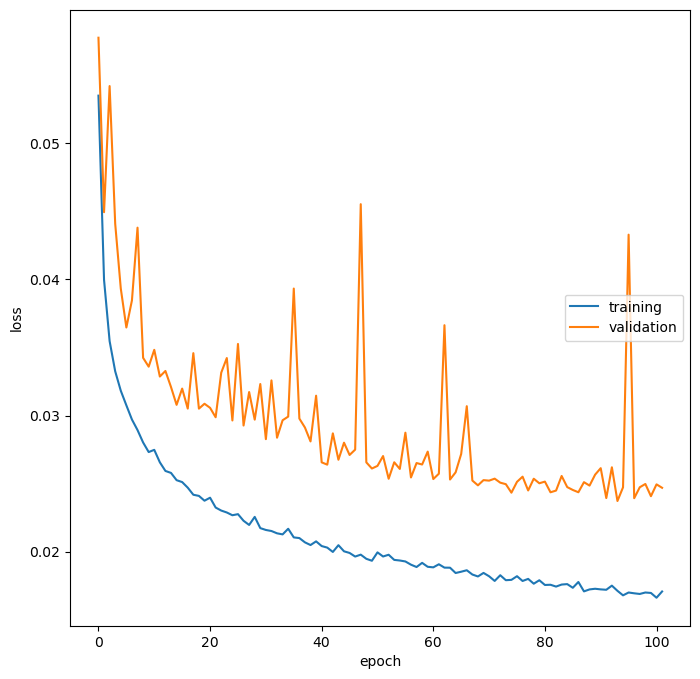

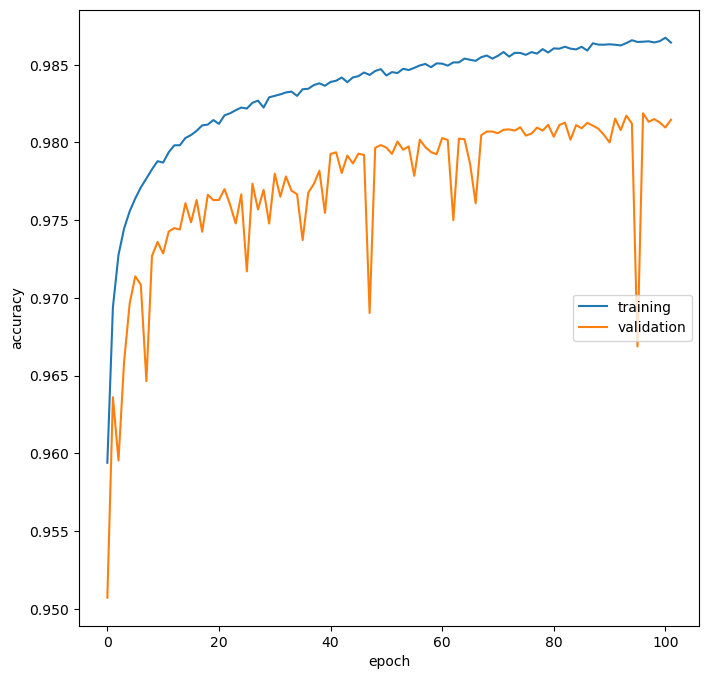

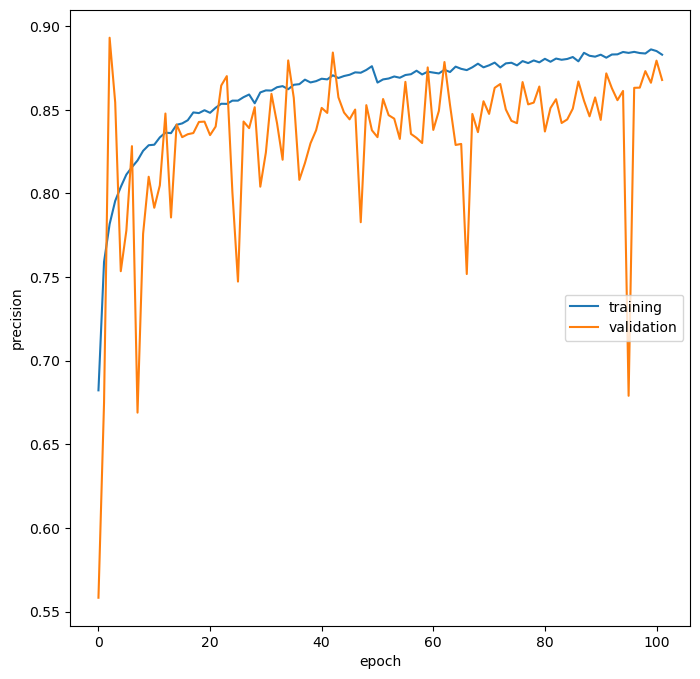

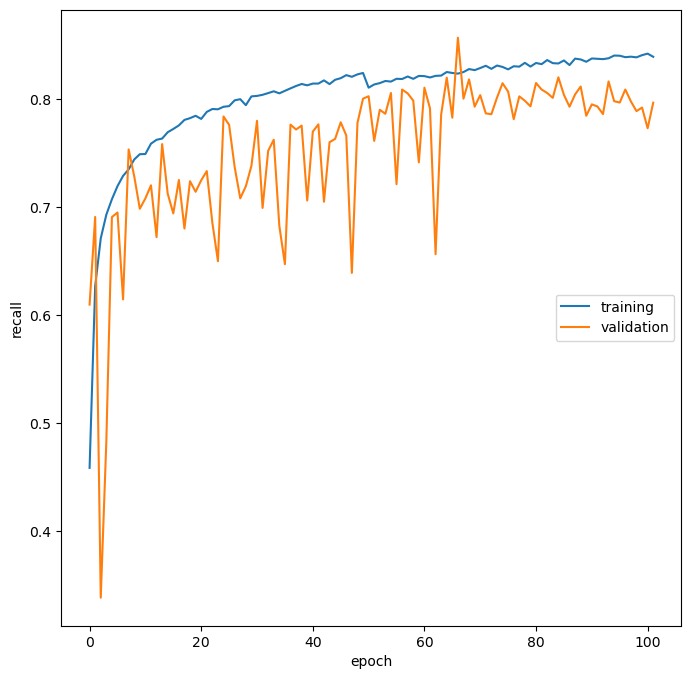

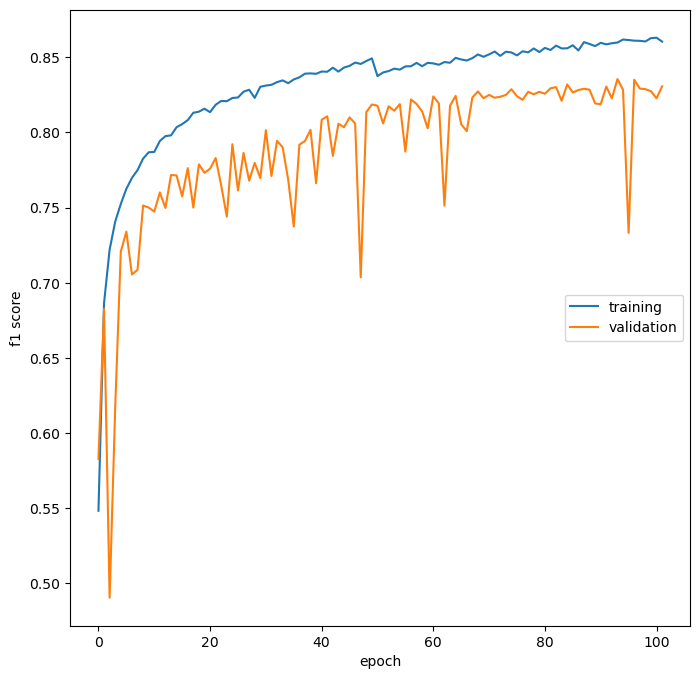

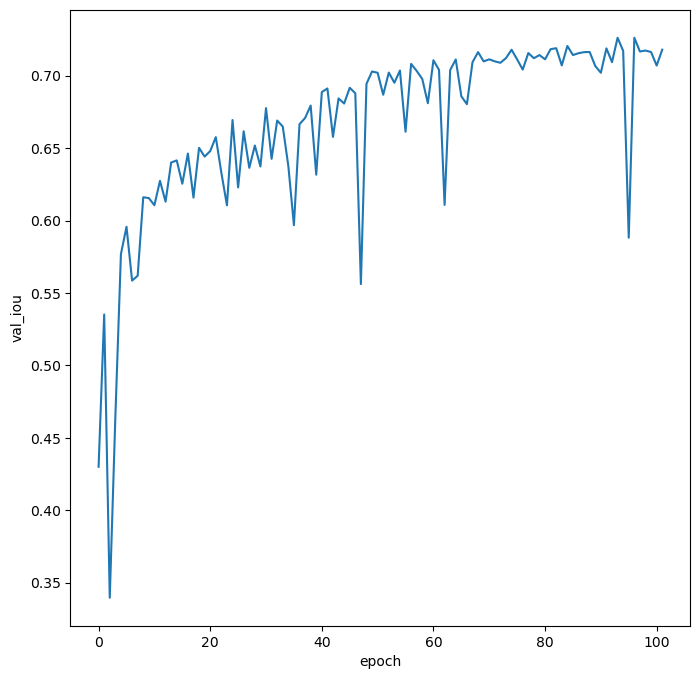

In [6]:
plot_history(history)

In [4]:
from torchvision.models import resnet50

model = TransUNet(resnet50(), 8, 8, 1024).to(DEVICE)

bce = nn.BCEWithLogitsLoss()
#focal = FocalLoss(gamma=2, alpha=-1)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'iou' : []
}

# training loop
for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, bce, adam, i+1)
    val_result = model_predict(val_dataloader, model, bce, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:49<00:00,  1.92batch/s]


iou:0.31804317235946655


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:37<00:00,  2.16batch/s]


iou:0.39370477199554443


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:59<00:00,  1.76batch/s]


iou:0.45968425273895264


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:37<00:00,  2.16batch/s]


iou:0.49940410256385803


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:37<00:00,  2.16batch/s]


iou:0.542053759098053


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:03<00:00,  1.70batch/s]


iou:0.4983581602573395


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:36<00:00,  2.17batch/s]


iou:0.4816744923591614


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:36<00:00,  2.17batch/s]


iou:0.5750167965888977


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:36<00:00,  2.17batch/s]


iou:0.5576487183570862


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:59<00:00,  1.75batch/s]


iou:0.5735536217689514
training accuracy:0.978, precision:0.824, recall:0.745, f1:0.783
validation accuracy:0.972, precision:0.850, recall:0.628, f1:0.722
iou:0.574


In [4]:
from torchvision.models import resnet50

model = TransUNet(resnet50(), 8, 8, 3072).to(DEVICE)

focal = FocalLoss(gamma=1, alpha=-1)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'iou' : []
}

# training loop
for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)
    
    if ((i+1)%10 == 0):
        state = {
            'epoch' : i,
            'state_dict': model.state_dict(),
            'optimizer': adam.state_dict(),
            'history' : history
        }
        torch.save(state, f"model_segmentation_{i+1}.pth")

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.74batch/s]


iou:0.4300113916397095, f1:0.5828045606613159


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.76batch/s]


iou:0.535152018070221, f1:0.682691216468811


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.3396076261997223, f1:0.49044081568717957


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.74batch/s]


iou:0.4641483724117279, f1:0.6168060898780823


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.76batch/s]


iou:0.576872706413269, f1:0.7207016944885254


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.76batch/s]


iou:0.5957266688346863, f1:0.7340080738067627


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.74batch/s]


iou:0.5585501790046692, f1:0.7054796814918518


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.76batch/s]


iou:0.5618883371353149, f1:0.7086407542228699


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.75batch/s]


iou:0.6160874366760254, f1:0.7514161467552185


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6155223846435547, f1:0.750029981136322


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.6105811595916748, f1:0.7473706603050232


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.6274321675300598, f1:0.7601083517074585


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.74batch/s]


iou:0.6130436062812805, f1:0.7497787475585938


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:21<00:00,  1.61batch/s]


iou:0.6400431990623474, f1:0.7716951370239258


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.6415409445762634, f1:0.7714127898216248


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6254292130470276, f1:0.7574554681777954


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.6462461948394775, f1:0.7762672305107117


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.61588054895401, f1:0.7500333189964294


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.74batch/s]


iou:0.6501957774162292, f1:0.778793215751648


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.75batch/s]


iou:0.6441662907600403, f1:0.7731687426567078


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.6479663252830505, f1:0.7759019136428833


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:02<00:00,  1.73batch/s]


iou:0.6576019525527954, f1:0.7829908728599548


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.76batch/s]


iou:0.6329342722892761, f1:0.7646133899688721


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.6104975342750549, f1:0.7439801692962646


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:01<00:00,  1.74batch/s]


iou:0.6694214344024658, f1:0.7921991944313049


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.6228662133216858, f1:0.7614220976829529


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.661622166633606, f1:0.7863932847976685


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:01<00:00,  1.74batch/s]


iou:0.6364156007766724, f1:0.7679653763771057


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.73batch/s]


iou:0.6517936587333679, f1:0.7797908186912537


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:21<00:00,  1.61batch/s]


iou:0.6373299360275269, f1:0.7696551084518433


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:01<00:00,  1.74batch/s]


iou:0.6776300668716431, f1:0.8015221953392029


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.75batch/s]


iou:0.6426217555999756, f1:0.7710572481155396


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6690452098846436, f1:0.7944420576095581


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:02<00:00,  1.73batch/s]


iou:0.6649245619773865, f1:0.7901633381843567


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6376409530639648, f1:0.7686102986335754


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.5968262553215027, f1:0.7374067306518555


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:06<00:00,  1.71batch/s]


iou:0.6665595173835754, f1:0.7918880581855774


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:22<00:00,  1.60batch/s]


iou:0.6707965731620789, f1:0.7942745685577393


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6794172525405884, f1:0.8017657399177551


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:02<00:00,  1.74batch/s]


iou:0.6316675543785095, f1:0.7662317752838135


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.74batch/s]


iou:0.6887272596359253, f1:0.8084313869476318


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6911977529525757, f1:0.8107649087905884


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6577577590942383, f1:0.7844154238700867


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.75batch/s]


iou:0.684336245059967, f1:0.8057827353477478


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.75batch/s]


iou:0.6807906031608582, f1:0.8034680485725403


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:02<00:00,  1.73batch/s]


iou:0.6916787624359131, f1:0.810035765171051


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.6878970861434937, f1:0.8059825301170349


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.5561418533325195, f1:0.7035835385322571


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.72batch/s]


iou:0.6943598389625549, f1:0.813586413860321


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:00<00:00,  1.75batch/s]


iou:0.7029212713241577, f1:0.8186274170875549
training accuracy:0.985, precision:0.876, recall:0.824, f1:0.849
validation accuracy:0.980, precision:0.838, recall:0.800, f1:0.819
iou:0.703


In [4]:
from torchvision.models import resnet50

model = TransUNet(resnet50(), 8, 8, 1024).to(DEVICE)

focal = FocalLoss(gamma=2, alpha=-1)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'iou' : []
}

# training loop
for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:57<00:00,  1.18batch/s]


iou:0.1760156750679016, f1:0.2864474058151245


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:29<00:00,  1.41batch/s]


iou:0.4028392732143402, f1:0.5695726871490479


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:29<00:00,  1.41batch/s]


iou:0.391388475894928, f1:0.5538542866706848


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [03:19<00:00,  1.05batch/s]


iou:0.4803784191608429, f1:0.6432474255561829


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:30<00:00,  1.39batch/s]


iou:0.46039879322052, f1:0.6229540705680847


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:30<00:00,  1.39batch/s]


iou:0.53851717710495, f1:0.6945183277130127


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:47<00:00,  1.25batch/s]


iou:0.4592268764972687, f1:0.6234158873558044


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:30<00:00,  1.39batch/s]


iou:0.4469151198863983, f1:0.6096571087837219


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:30<00:00,  1.39batch/s]


iou:0.5572065711021423, f1:0.7122598886489868


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:43<00:00,  1.29batch/s]


iou:0.5771514177322388, f1:0.7275652885437012
training accuracy:0.978, precision:0.821, recall:0.741, f1:0.779
validation accuracy:0.964, precision:0.654, recall:0.820, f1:0.728
iou:0.577


In [4]:
from torchvision.models import resnet50

model = TransUNet(resnet50(), 8, 8, 1024).to(DEVICE)

focal = FocalLoss(gamma=2, alpha=0.65)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'iou' : []
}

# training loop
for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:49<00:00,  1.92batch/s]


iou:0.32000574469566345


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:37<00:00,  2.14batch/s]


iou:0.23273728787899017


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:52<00:00,  1.87batch/s]


iou:0.20672400295734406


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:36<00:00,  2.17batch/s]


iou:0.4853854477405548


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:36<00:00,  2.17batch/s]


iou:0.5404778122901917


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [02:14<00:00,  1.56batch/s]


iou:0.5659078359603882


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:37<00:00,  2.16batch/s]


iou:0.5723304748535156


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:37<00:00,  2.14batch/s]


iou:0.5987218618392944


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:56<00:00,  1.80batch/s]


iou:0.587415337562561


Predicting: 100%|█████████████████████████████████████████████████████████████████| 210/210 [01:36<00:00,  2.17batch/s]


iou:0.5888938903808594
training accuracy:0.976, precision:0.749, recall:0.819, f1:0.782
validation accuracy:0.967, precision:0.679, recall:0.808, f1:0.738
iou:0.589


# Continue Training

In [4]:
from torchvision.models import resnet50
path = "models_segmentation/model_segmentation_70.pth"
checkpoint = torch.load(path)

model = TransUNet(resnet50(), 8, 8, 3072).to(DEVICE)
focal = FocalLoss(gamma=1, alpha=-1)
adam = torch.optim.Adam(model.parameters(), lr=LR)

model.load_state_dict(checkpoint['state_dict'])
adam.load_state_dict(checkpoint['optimizer'])

history = checkpoint['history']
epoch_start = checkpoint['epoch']
print(epoch_start)
print_history(history)

69
training accuracy:0.986, precision:0.877, recall:0.829, f1:0.852
validation accuracy:0.981, precision:0.848, recall:0.804, f1:0.825
iou:0.711


In [5]:
EPOCH = 100

# training loop
for i in range(epoch_start, EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)
    
    if ((i+1)%10 == 0):
        state = {
            'epoch' : i,
            'state_dict': model.state_dict(),
            'optimizer': adam.state_dict(),
            'history' : history
        }
        torch.save(state, f"model_segmentation_{i+1}.pth")

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:16<00:00,  1.64batch/s]


iou:0.7099074721336365, f1:0.8231218457221985


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:04<00:00,  1.72batch/s]


iou:0.7089189291000366, f1:0.8237738609313965


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:04<00:00,  1.72batch/s]


iou:0.7121423482894897, f1:0.8249757885932922


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:16<00:00,  1.64batch/s]


iou:0.7179356217384338, f1:0.8287782669067383


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.72batch/s]


iou:0.7112537026405334, f1:0.8240648508071899


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.72batch/s]


iou:0.704215943813324, f1:0.8217564225196838


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:23<00:00,  1.59batch/s]


iou:0.7156445980072021, f1:0.8270706534385681


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.72batch/s]


iou:0.7120890617370605, f1:0.8254038095474243


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.72batch/s]


iou:0.7142578363418579, f1:0.8270659446716309


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:17<00:00,  1.63batch/s]


iou:0.7113415598869324, f1:0.825771152973175


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.72batch/s]


iou:0.7183379530906677, f1:0.8293771743774414


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:03<00:00,  1.72batch/s]


iou:0.7190004587173462, f1:0.8301841616630554


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:06<00:00,  1.70batch/s]


iou:0.7071149349212646, f1:0.821092963218689


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7205366492271423, f1:0.8319962024688721


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7142810225486755, f1:0.8266105055809021


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:16<00:00,  1.64batch/s]


iou:0.7155459523200989, f1:0.8282512426376343


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7162818312644958, f1:0.8290892243385315


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7163568735122681, f1:0.8284671306610107


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:08<00:00,  1.69batch/s]


iou:0.7066863179206848, f1:0.8193429112434387


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:59<00:00,  1.76batch/s]


iou:0.7020442485809326, f1:0.818783700466156


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7188804745674133, f1:0.830568253993988


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:17<00:00,  1.63batch/s]


iou:0.7093514204025269, f1:0.8226858377456665


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7262330055236816, f1:0.8355527520179749


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7171525955200195, f1:0.8284191489219666


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:45<00:00,  1.47batch/s]


iou:0.5881813764572144, f1:0.733180820941925


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7262318134307861, f1:0.8350834846496582


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7167184352874756, f1:0.8292354941368103


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:16<00:00,  1.64batch/s]


iou:0.7173724174499512, f1:0.8288128972053528


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7163480520248413, f1:0.8274666666984558


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [03:58<00:00,  1.76batch/s]


iou:0.7070115804672241, f1:0.8227099776268005


Predicting: 100%|█████████████████████████████████████████████████████████████████| 420/420 [04:23<00:00,  1.60batch/s]


iou:0.7179859280586243, f1:0.8307003378868103
training accuracy:0.986, precision:0.883, recall:0.839, f1:0.860
validation accuracy:0.981, precision:0.868, recall:0.797, f1:0.831
iou:0.718


***

In [4]:
from torchvision.models import resnet50

path = "segmentation gamma 1\model_segmentation_30.pth"
checkpoint = torch.load(path)

model = TransUNet(resnet50(), 8, 8, 1024).to(DEVICE)
focal = FocalLoss(gamma=1, alpha=-1)

model.load_state_dict(checkpoint['state_dict'])

val_result = model_predict(val_dataloader, model, focal, silent=False)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 280/280 [03:14<00:00,  1.44batch/s]


iou:0.6309375166893005, f1:0.7706986665725708


In [5]:
print(f"accuracy:{val_result['accuracy']:.3f}, precision:{val_result['precision']:.3f}, recall:{val_result['recall']:.3f}, f1:{val_result['f1_score']:.3f}, iou:{val_result['iou']:.3f}")

accuracy:0.975, precision:0.842, recall:0.711, f1:0.771, iou:0.631


In [ ]:
plot_history(history)